In [1]:
import numpy as np
import pandas as pd 
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings("ignore")

#pd.options.display.max_rows = None
#pd.options.display.max_columns = None

In [2]:
game = pd.read_csv('game_info.csv')

display(game.head(1))
print (game.shape)

,id,slug,name,metacritic,released,tba,updated,website,rating,rating_top,...,developers,genres,publishers,esrb_rating,added_status_yet,added_status_owned,added_status_beaten,added_status_toplay,added_status_dropped,added_status_playing
0,1,dgeneration-hd,D/Generation HD,NaN,2015-10-23,False,2019-09-17T11:58:57,http://dgeneration.net,0.0,0,...,West Coast Software||West Coast Software Limited,Adventure||Puzzle,West Coast Software||West Coast Software Limited,Everyone 10+,3,70,0,2,0,0


(345667, 27)


In [3]:
game.isnull().sum()

id                           0
slug                         2
name                         2
metacritic              342428
released                 27201
tba                          0
updated                      0
website                 284812
rating                       0
rating_top                   0
playtime                     0
achievements_count           0
ratings_count                0
suggestions_count            0
game_series_count            0
reviews_count                0
platforms                 3391
developers                6236
genres                   67190
publishers              214606
esrb_rating             290551
added_status_yet             0
added_status_owned           0
added_status_beaten          0
added_status_toplay          0
added_status_dropped         0
added_status_playing         0
dtype: int64

# Cleaning

In [4]:
# Dropping missing datas more than 80%
game.drop(['id','metacritic','released','esrb_rating',
           'updated','developers','publishers','website'],axis = 1,inplace = True)

# Dropping not meaningful data 
game.drop(['slug'],axis = 1,inplace = True)

# Dropping the game without name
game = game[~game['name'].isnull()].reset_index(drop=True)

In [5]:
# Replace the missing value with unknown instead of Null value 
game['genres'] = game['genres'].fillna('unknown_genre')

game['platforms'] = game['platforms'].fillna('unknown_plat')

In [6]:
for i in range (0,len(game.isnull().sum())):
    if game.isnull().sum()[i] == 0:
        continue
    else:
        print('unclean')
print('clean')

clean


# Feature Engineering

In [7]:
#game['updated'] = pd.to_datetime(game['updated'])
genres = game['genres'].str.get_dummies('|')
platforms = game['platforms'].str.get_dummies('|')

game['tba'] = game['tba'].map({False: '0',True:'1'})

game['rating'] = round(game['rating']).astype(int)

In [8]:
game = game.join(genres)
game = game.join(platforms)
game.drop(['genres','platforms'],axis = 1,inplace = True)

In [9]:
game.head(10)

,name,tba,rating,rating_top,playtime,achievements_count,ratings_count,suggestions_count,game_series_count,reviews_count,...,Web,Wii,Wii U,Xbox,Xbox 360,Xbox One,iOS,mac,macOS,unknown_plat
0,D/Generation HD,0,0,0,1,80,0,283,0,0,...,0,0,0,0,0,1,0,0,1,0
1,G Prime Into The Rain,0,0,0,0,26,0,375,0,0,...,0,0,0,0,0,1,0,0,1,0
2,Land Sliders,0,0,0,0,0,1,71,0,1,...,0,0,0,0,0,0,1,0,0,0
3,Pixel Gear,0,0,0,0,0,0,443,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Gods and Idols,0,0,0,1,0,4,268,0,4,...,0,0,0,0,0,0,0,0,0,0
5,Plague venue,0,0,0,0,0,0,45,0,0,...,1,0,0,0,0,0,0,0,0,0
6,The Moon Sliver (itch),0,0,0,0,0,0,121,0,0,...,0,0,0,0,0,0,0,0,1,0
7,Red Entity,0,0,0,0,0,0,33,0,0,...,0,0,0,0,0,0,0,0,1,0
8,Rollman (itch),0,0,0,0,0,0,131,0,0,...,0,0,0,0,0,0,0,0,0,0
9,HippiesVsCops,0,0,0,0,0,0,32,0,0,...,0,0,0,0,0,0,0,0,0,0


# EDA

In [10]:
genres_list = list(genres.columns.values.tolist())
genres_counts = []
for i in genres_list:
    count = game[i].value_counts()[1]
    genres_counts.append(count)

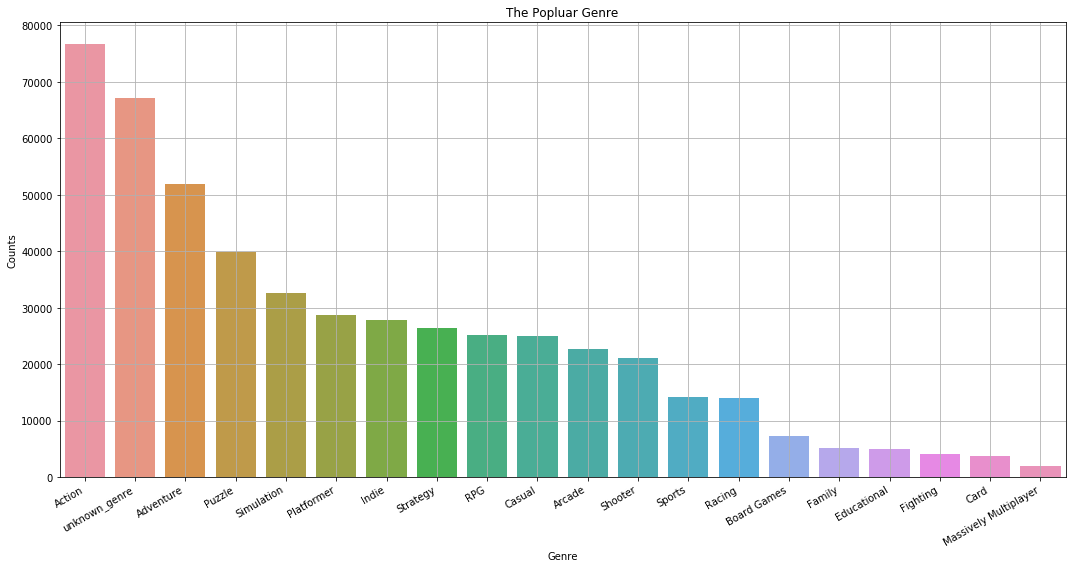

In [11]:
plot1 = pd.DataFrame({'Genre' : genres_list , 'Counts' : genres_counts})
plot1 = plot1.sort_values('Counts',ascending=False)
plt.figure(figsize = (15,8))
sns.barplot(x=plot1['Genre'], y=plot1['Counts']).set_title("The Popluar Genre")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.grid()
plt.show()

In [12]:
platforms_list = list(platforms.columns.values.tolist())
platforms_counts = []
for i in platforms_list:
    count = game[i].value_counts()[1]
    platforms_counts.append(count)

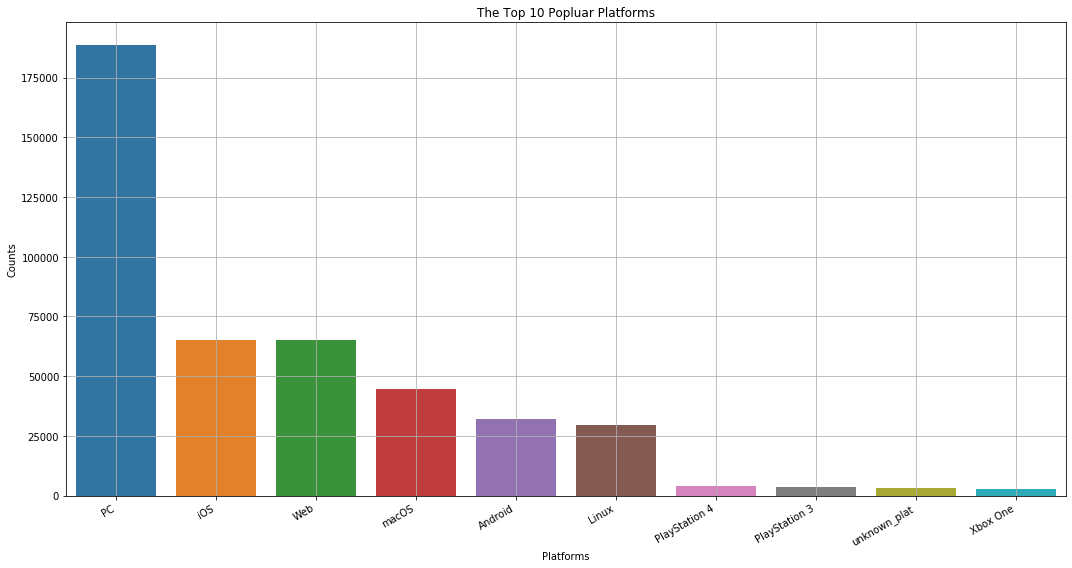

In [13]:
plot2 = pd.DataFrame({'Platforms' : platforms_list , 'Counts' : platforms_counts})
plot2 = plot2.sort_values('Counts',ascending=False)
plt.figure(figsize = (15,8))
sns.barplot(x=plot2['Platforms'][0:10], y=plot2['Counts'][0:10]).set_title("The Top 10 Popluar Platforms")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.grid()
plt.show()

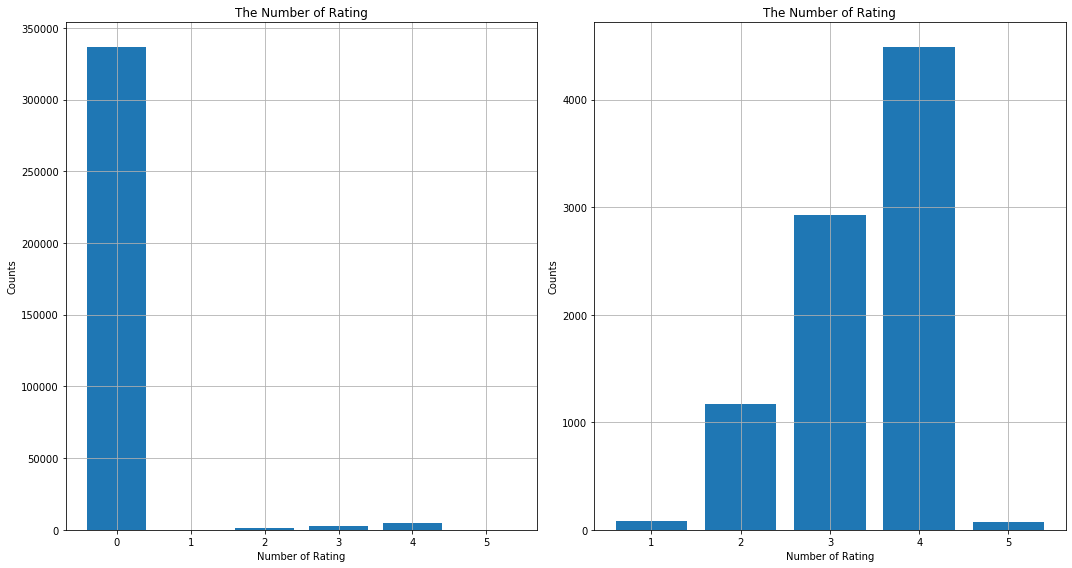

In [14]:
fig, ax = plt.subplots(1,2,figsize = (15,8))

ax[0].bar(game['rating'].value_counts().index, game['rating'].value_counts().values)

ax[1].bar(game['rating'].loc[game['rating'] != 0.0].value_counts().index, 
         game['rating'].loc[game['rating'] != 0.0].value_counts().values)


ax[0].set_title('The Number of Rating')
ax[1].set_title('The Number of Rating')
ax[0].set_xlabel('Number of Rating')
ax[1].set_xlabel('Number of Rating')
ax[0].set_ylabel('Counts')
ax[1].set_ylabel('Counts')
ax[0].grid()
ax[1].grid()
fig.tight_layout()
plt.show()

# A User Independent System

In [15]:
top_rated = game.sort_values(by=['rating'], ascending=False)
top_rated['name'].head(10)

309835                    PICROSS S2
308907                    God of War
306784                 NBA Street V3
310650             STEINS;GATE ELITE
306783             NBA Street Vol. 2
6192      GameMaker Studio 2 Desktop
291589                  Star Citizen
232737                      Supaplex
274150            Assemble with Care
168115                 Disco Elysium
Name: name, dtype: object

In [16]:
top_rated.head(10).loc[:,['rating','reviews_count']]

,rating,reviews_count
309835,5,7
308907,5,1783
306784,5,9
310650,5,10
306783,5,7
6192,5,7
291589,5,6
232737,5,6
274150,5,10
168115,5,22


In [17]:
top_rated_v2 = game.sort_values(by=['rating'], ascending=False)

top_rated_v2 = top_rated_v2.loc[top_rated_v2['reviews_count']>1500]

top_rated_v2.loc[:,['name','rating','reviews_count']].head(10)

,name,rating,reviews_count
308907,God of War,5,1783
291899,Portal 2,5,2337
152701,Uncharted 4: A Thief’s End,5,1591
238383,The Witcher 3: Wild Hunt,5,2462
185152,Red Dead Redemption 2,5,1646
290500,BioShock Infinite,4,1811
303272,Tomb Raider (2013),4,1540
37736,Portal,4,1925
37746,Half-Life 2,4,1602
250429,Grand Theft Auto V,4,2667


In [18]:
top_rated_action = game.sort_values(by=['rating','reviews_count'], ascending=False)

top_rated_action = top_rated_action.loc[(top_rated_action['reviews_count']>1500) & 
                                        (top_rated_action['Action'] == 1) ]

top_rated_action.loc[:,['name','rating','reviews_count','Action']].head(10)

,name,rating,reviews_count,Action
308907,God of War,5,1783,1
185152,Red Dead Redemption 2,5,1646,1
152701,Uncharted 4: A Thief’s End,5,1591,1
250429,Grand Theft Auto V,4,2667,1
37736,Portal,4,1925,1
307488,The Elder Scrolls V: Skyrim,4,1924,1
290500,BioShock Infinite,4,1811,1
37746,Half-Life 2,4,1602,1
183215,Horizon Zero Dawn,4,1587,1
152101,DOOM (2016),4,1548,1


In [19]:
top_rated_adventure = game.sort_values(by=['rating','reviews_count'], ascending=False)

top_rated_adventure = top_rated_adventure.loc[(top_rated_adventure['reviews_count']>1000) & 
                                              (top_rated_adventure['Adventure'] == 1) ]

top_rated_adventure.loc[:,['name','rating','reviews_count','Action']].head(10)

,name,rating,reviews_count,Action
152701,Uncharted 4: A Thief’s End,5,1591,1
262130,The Last Of Us Remastered,5,1351,1
289746,The Last Of Us,5,1202,1
37736,Portal,4,1925,1
249486,Life is Strange,4,1615,0
303272,Tomb Raider (2013),4,1540,1
3152,Limbo,4,1459,1
132456,The Legend of Zelda: Breath of the Wild,4,1166,1
294545,Grand Theft Auto IV,4,1140,1
230646,Journey,4,1084,0


In [20]:
top_rated_puzzle = game.sort_values(by=['rating','reviews_count'], ascending=False)

top_rated_puzzle = top_rated_puzzle.loc[(top_rated_puzzle['reviews_count']>450) & 
                                        (top_rated_puzzle['Puzzle'] == 1) ]

top_rated_puzzle.loc[:,['name','rating','reviews_count','Puzzle']].head(10)

,name,rating,reviews_count,Puzzle
291899,Portal 2,5,2337,1
37736,Portal,4,1925,1
3152,Limbo,4,1459,1
48088,INSIDE,4,1007,1
87897,Brothers - A Tale of Two Sons,4,787,1
38209,"Papers, Please",4,711,1
272882,FEZ,4,624,1
80840,Valiant Hearts: The Great War,4,577,1
192287,The Witness,4,553,1
284715,Trine 2: Complete Story,4,489,1


# Data Analysis

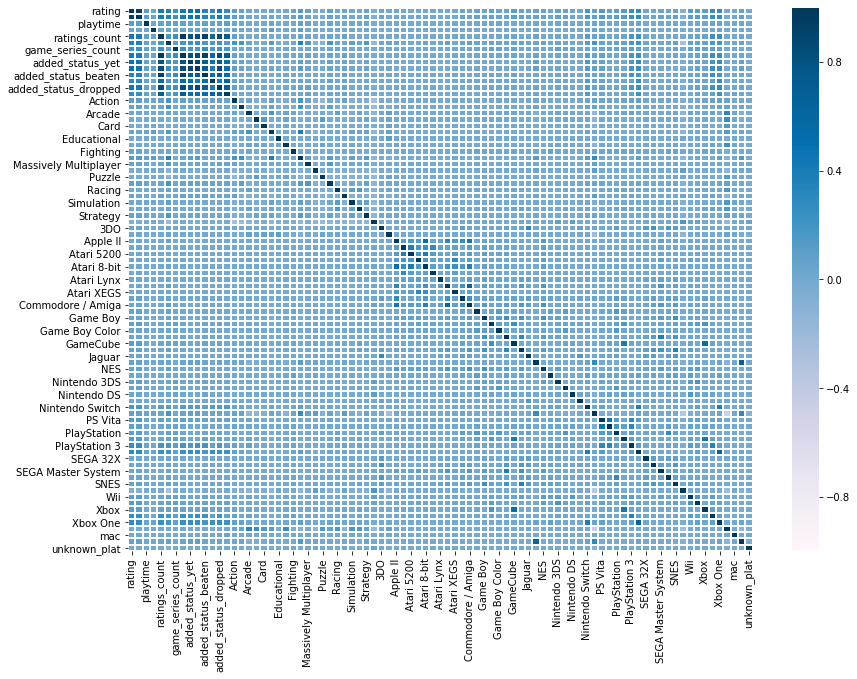

In [21]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 10)
ax=sns.heatmap(game.corr(), vmin=-1, vmax=1, cmap="PuBu", linewidths=1)

In [22]:
game.corr()[['rating']].query('rating >= 0.3 or rating <= -0.3').style.background_gradient(cmap="PuBu")  

,rating
rating,1
rating_top,0.935971
ratings_count,0.417017
suggestions_count,0.351649
reviews_count,0.417152
added_status_yet,0.473819
added_status_owned,0.500076
added_status_beaten,0.351428
added_status_dropped,0.436792


In [23]:
#'rating_top','ratings_count','suggestions_count','reviews_count',
#     'added_status_yet','added_status_owned','added_status_beaten',
#     'added_status_toplay','added_status_dropped'

X = game[['rating_top','suggestions_count',
     'added_status_yet',
     'added_status_dropped']]
y = game['rating']

In [24]:
X_withconst = sm.add_constant(X)
sm.OLS(y, X_withconst).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                 6.305e+05
Date:                Wed, 15 Apr 2020   Prob (F-statistic):               0.00
Time:                        16:09:49   Log-Likelihood:                 85538.
No. Observations:              345665   AIC:                        -1.711e+05
Df Residuals:                  345660   BIC:                        -1.710e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0038      0.000     -8.853      0.000      -0.005      -0.003
rating_top               0.7965      0.001   1288.660      0.000       0.795       0.798
suggestions_count      6.61e-05   2.91e-06     22.738      0.000    6.04e-05    7.18e-05
added_status_yet         0.0041   8.29e-05     49.003      0.000       0.004       0.004
added_status_dropped     0.0018    6.9e-05     26.302      0.000       0.002       0.002
==============================================================================
Omnibus:                   532254.146   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        614108016.920
Skew:                          -9.448   Prob(JB):                         0.00
Kurtosis:                     208.624   Cond. No.                         306.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
ans = pd.Series([variance_inflation_factor(X.values, i)
               for i in range(X.shape[1])], 
              index= X.columns)

In [26]:
ans.sort_values(ascending = False).apply(lambda x: '%.5f' % x)

added_status_yet        2.34043
added_status_dropped    2.24685
rating_top              1.42660
suggestions_count       1.16480
dtype: object

VIF

        ratings_count           38600.87168
        reviews_count           44.15528
        added_status_owned      10.72255
        
p - value

        added_status_beaten	1.406e-05	2.33e-05	0.603	0.546	-3.16e-05	5.97e-05
        added_status_toplay	-9.592e-05	6.34e-05	-1.512	0.131	-0.000	2.84e-05

In [27]:
X_withconst = sm.add_constant(X)
linear_reg = sm.OLS(y, X_withconst).fit()
linear_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                 6.305e+05
Date:                Wed, 15 Apr 2020   Prob (F-statistic):               0.00
Time:                        16:09:50   Log-Likelihood:                 85538.
No. Observations:              345665   AIC:                        -1.711e+05
Df Residuals:                  345660   BIC:                        -1.710e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0038      0.000     -8.853      0.000      -0.005      -0.003
rating_top               0.7965      0.001   1288.660      0.000       0.795       0.798
suggestions_count      6.61e-05   2.91e-06     22.738      0.000    6.04e-05    7.18e-05
added_status_yet         0.0041   8.29e-05     49.003      0.000       0.004       0.004
added_status_dropped     0.0018    6.9e-05     26.302      0.000       0.002       0.002
==============================================================================
Omnibus:                   532254.146   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        614108016.920
Skew:                          -9.448   Prob(JB):                         0.00
Kurtosis:                     208.624   Cond. No.                         306.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

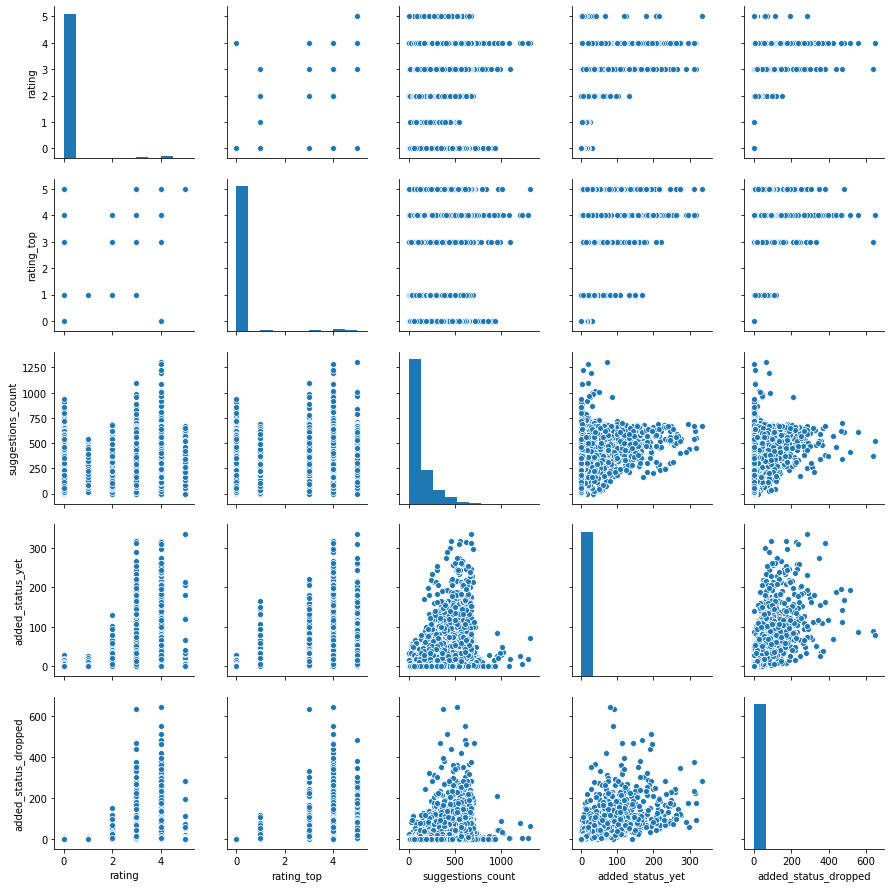

In [38]:
sns.pairplot(game[['rating','rating_top','suggestions_count',
                   'added_status_yet','added_status_dropped']]);
plt.show()

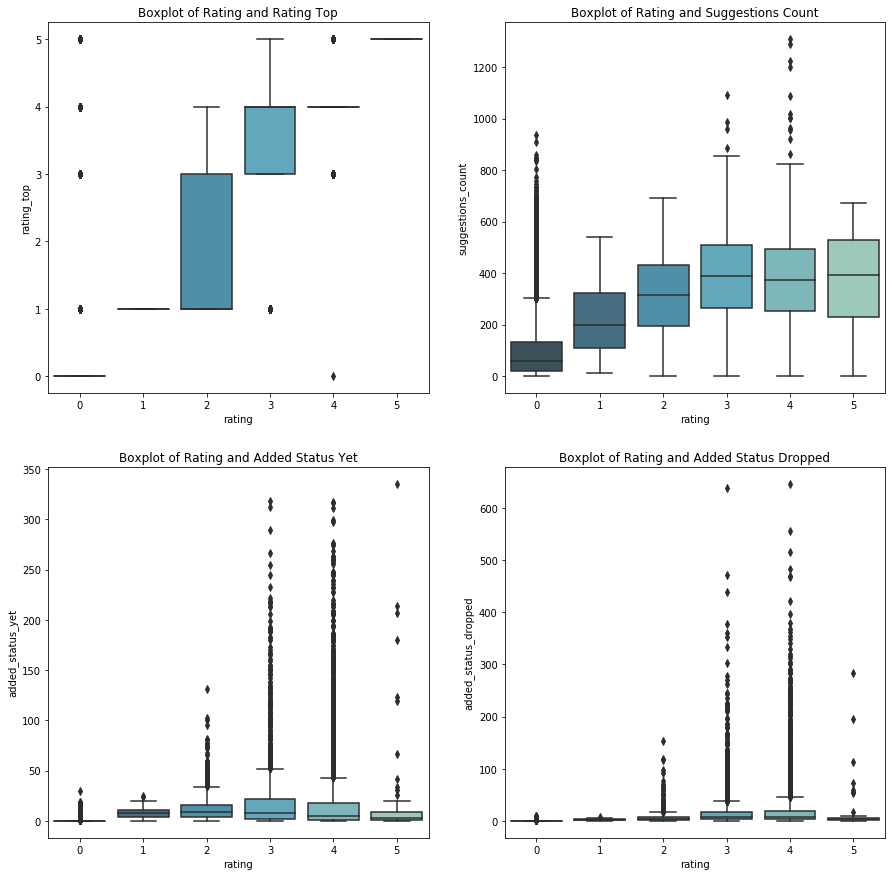

In [29]:
fig, axs = plt.subplots(2,2,figsize=(15, 15))
sns.boxplot(x='rating',y='rating_top',data=game,palette='GnBu_d',
            ax=axs[0,0]).set_title("Boxplot of Rating and Rating Top")

sns.boxplot(x='rating',y='suggestions_count',data=game,palette='GnBu_d',
            ax=axs[0,1]).set_title("Boxplot of Rating and Suggestions Count")

sns.boxplot(x='rating',y='added_status_yet',data=game,palette='GnBu_d',
            ax=axs[1,0]).set_title("Boxplot of Rating and Added Status Yet")

sns.boxplot(x='rating',y='added_status_dropped',data=game,palette='GnBu_d',
            ax=axs[1,1]).set_title("Boxplot of Rating and Added Status Dropped")



plt.show()

# Modeling

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [40]:
X = game[['rating_top','suggestions_count',
     'added_status_yet','added_status_dropped']]
y = game['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

In [52]:
logreg = LogisticRegression(solver = 'lbfgs',multi_class='auto')
logreg.fit(X_train, y_train)

print(f'The accuracy score on the train set: {logreg.score(X_train,y_train)}')
print(f'The accuracy score on the test set: {logreg.score(X_test,y_test)}')

The accuracy score on the train set: 0.9845266877440952
The accuracy score on the test set: 0.9844840887174542


In [48]:
my_random_forest = RandomForestClassifier(n_estimators=30)
my_random_forest.fit(X_train, y_train)

print(f'The accuracy score on the train set: {my_random_forest.score(X_train,y_train)}')
print(f'The accuracy score on the test set: {my_random_forest.score(X_test,y_test)}')

The accuracy score on the train set: 0.9996900378153866
The accuracy score on the test set: 0.9895756991321119


In [49]:
from sklearn.metrics import confusion_matrix
preds = logreg.predict(X_test)
con_mat = confusion_matrix(y_test,preds)
con_mat

array([[100783,      0,     46,     81,    148,      4],
       [     9,      0,      1,     10,     11,      0],
       [    58,      0,     14,    136,    146,      0],
       [    79,      0,      6,    158,    628,      0],
       [   106,      0,      1,    112,   1136,      0],
       [     8,      0,      0,      0,     19,      0]])

In [50]:
df_con_mat = pd.DataFrame(con_mat, 
                          columns = ['Predicted 0','Predicted 1',
                                     'Predicted 2','Predicted 3',
                                     'Predicted 4','Predicted 5'],
                          index = ['True 0','True 1',
                                   'True 2','True 3',
                                   'True 4','True 5'])

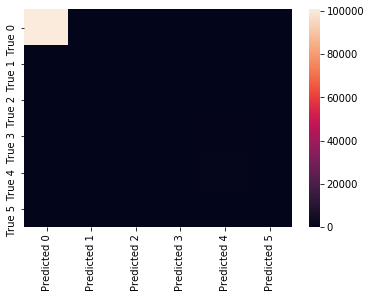

In [51]:
plt.figure()
sns.heatmap(df_con_mat)
plt.show()